Library and Data imports

In [2]:
# Libraries
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid',
              palette='muted',
              context='notebook')

import numpy as np
from scipy.stats import ttest_ind

from feature_engine.encoding import OneHotEncoder

from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

In [3]:
# Loading the data
train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')
test_id = test['PassengerId']

Quick understanding of the data.

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
train.shape

(8693, 14)

In [7]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

- Not many missing values per column, EDA and some imputation should be enough.

(0.0, 100.0)

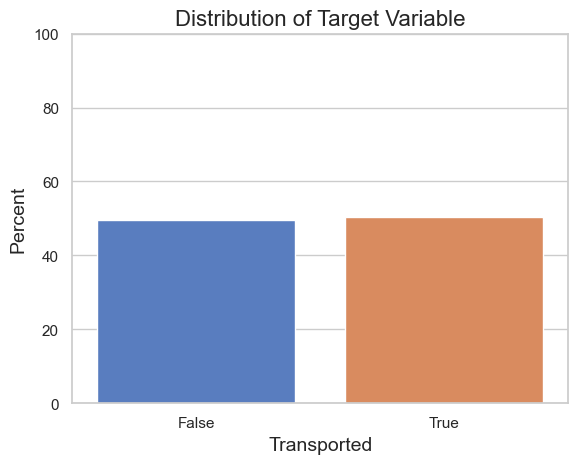

In [10]:
# Distribution of the target variable
sns.countplot(x='Transported', hue='Transported', legend=False, data=train, stat='percent')
plt.title('Distribution of Target Variable', fontsize=16)
plt.xlabel('Transported', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.ylim(0, 100)

EXPLORATORY DATA ANALYSIS

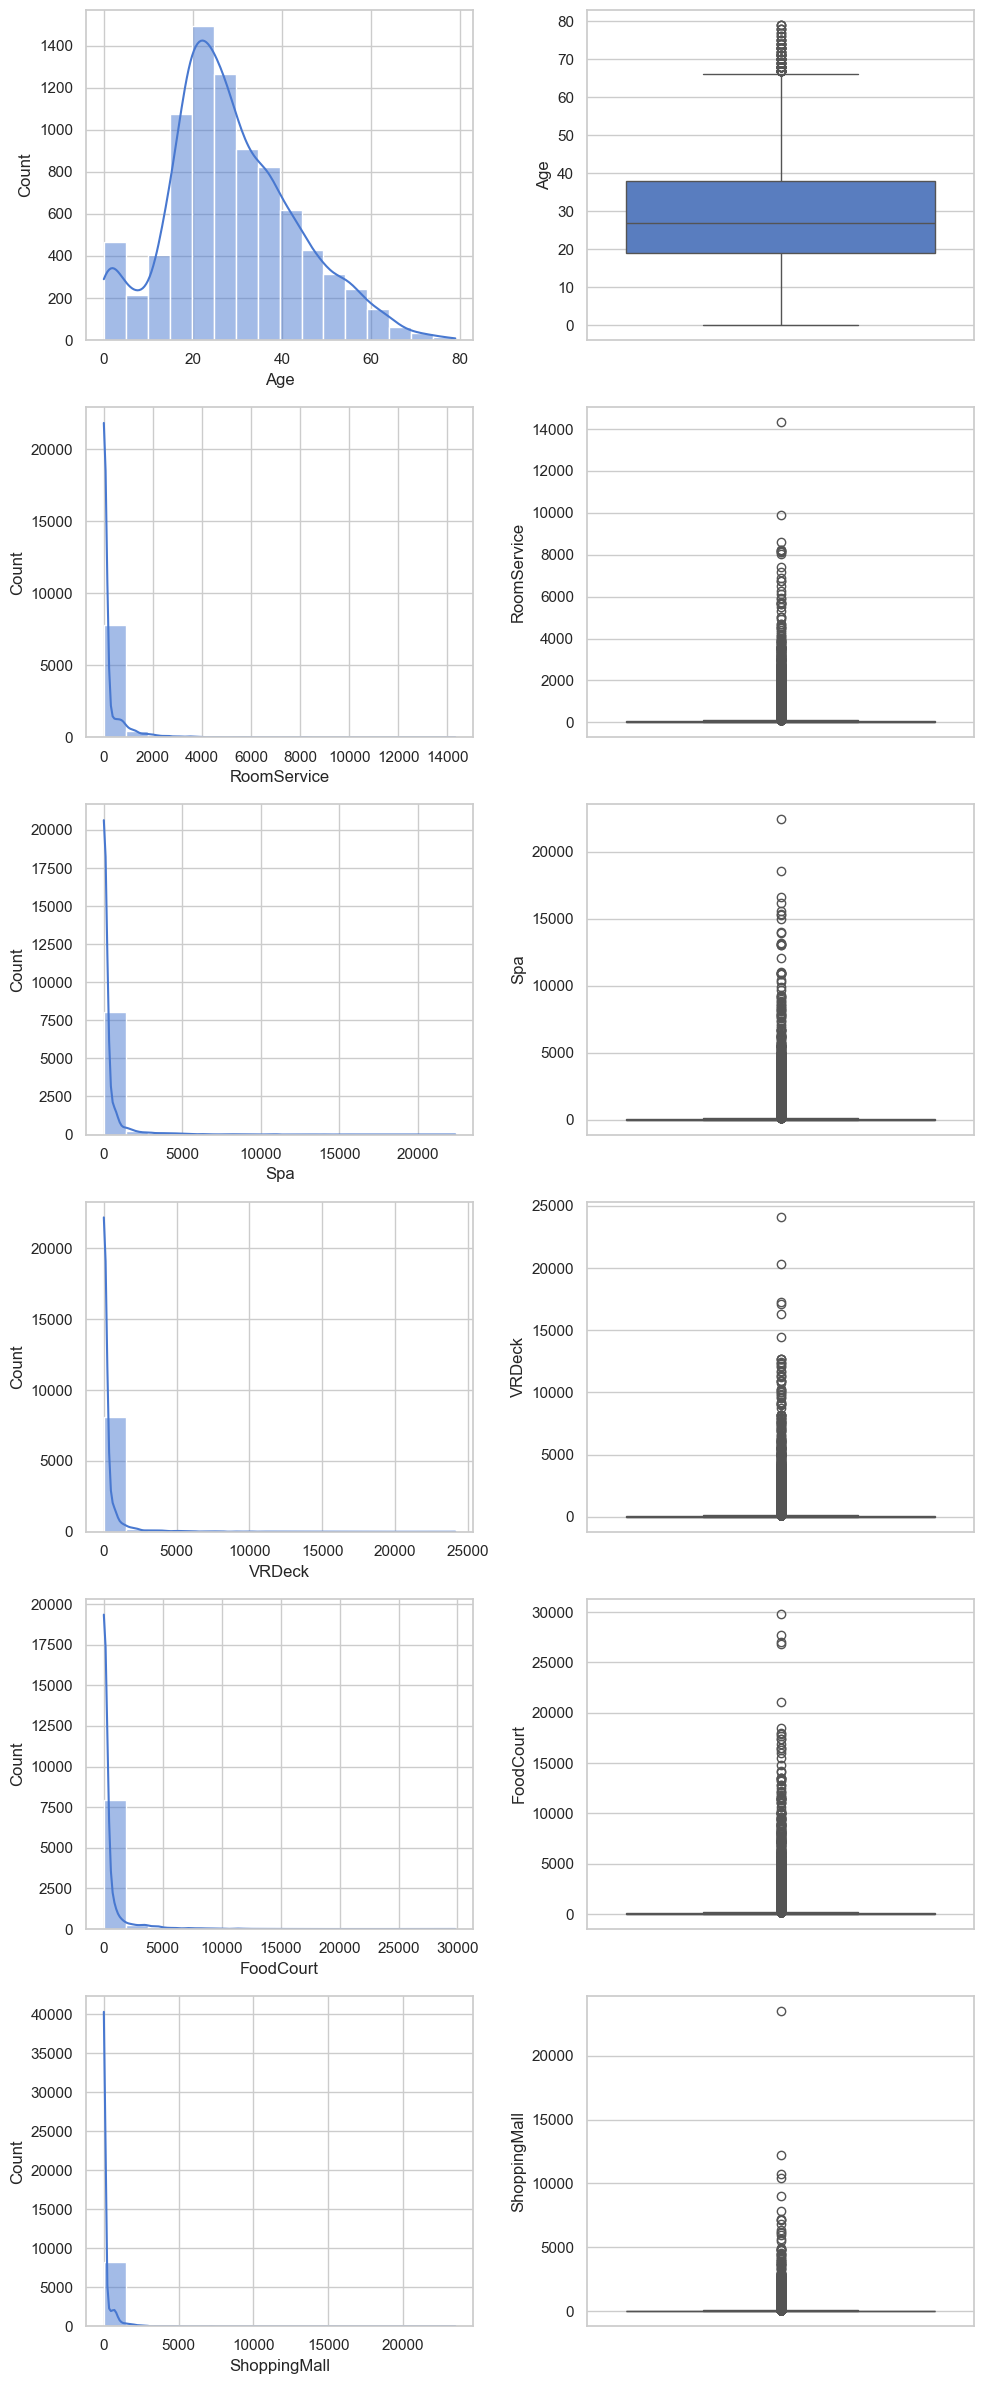

In [12]:
# Distribution of the numeric features
num_cols = ['Age', 'RoomService', 'Spa', 'VRDeck', 'FoodCourt', 'ShoppingMall']

def multiple_plots(columnstoplot, data):
    size = len(columnstoplot)
    fig, axs = plt.subplots(size, 2, figsize=(10, size * 4))

    for i, column in enumerate(columnstoplot):
        
        sns.histplot(data[column], kde=True, bins=16, ax=axs[i, 0])
        axs[i, 0].set_xlabel(column)

        sns.boxplot(data=data, y=column, ax=axs[i, 1])
        axs[i, 1].set_ylabel(column)

    plt.tight_layout()
    plt.show()

multiple_plots(num_cols, train)

- Distributions skewed and with a shit ton of outliers.
- Since one of the goals is to predict through RandomForestClassifier, those outliers shouldn't be a problem.

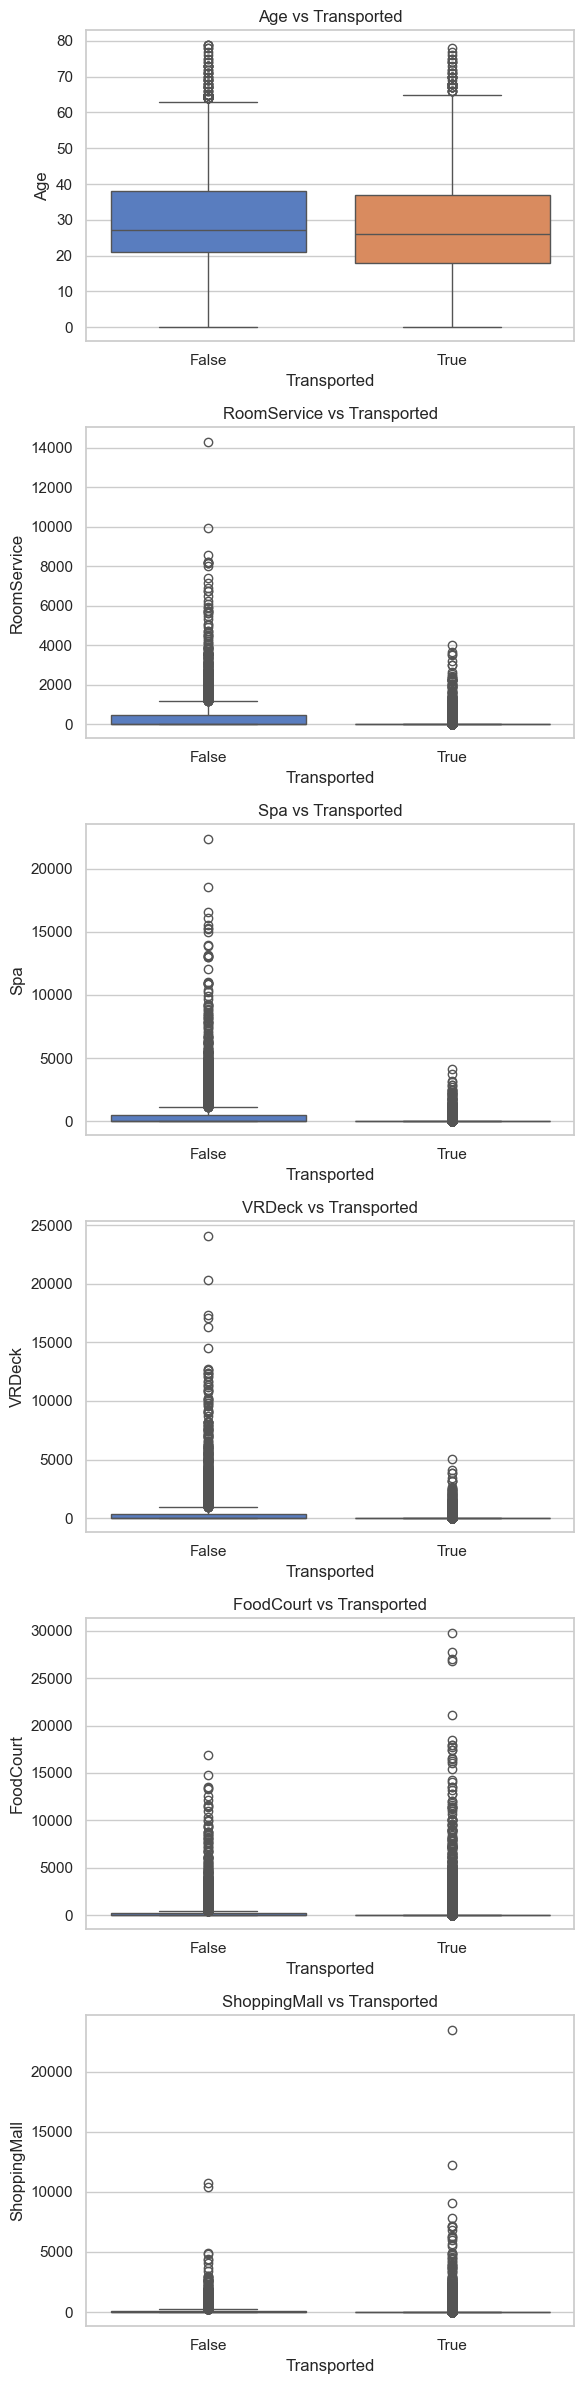

In [14]:
# Distribution across different classes
fig, axs = plt.subplots(nrows=len(num_cols), figsize=(6, (len(num_cols) * 4)))
for i, column in enumerate(num_cols):
    sns.boxplot(data=train, y=column, x='Transported', hue='Transported', legend=False, ax=axs[i])
    axs[i].set_title(f'{column} vs Transported')

plt.tight_layout()
plt.show()

- Doesn't seems to be much of a difference between classes in Age.
- In RoomService, Spa and VRDeck the higher outlier values all belong to the non-transported group.
- The opposite occurs with the FoodCourt and ShoppingMall attributes, although the difference is not as clear.
- It's common for FoodCourts to be located close or inside a Shopping Mall, so perhaps we could combine the spending variables for entertainment and consumer goods.
- A column for total expenditure could be a good idea too!

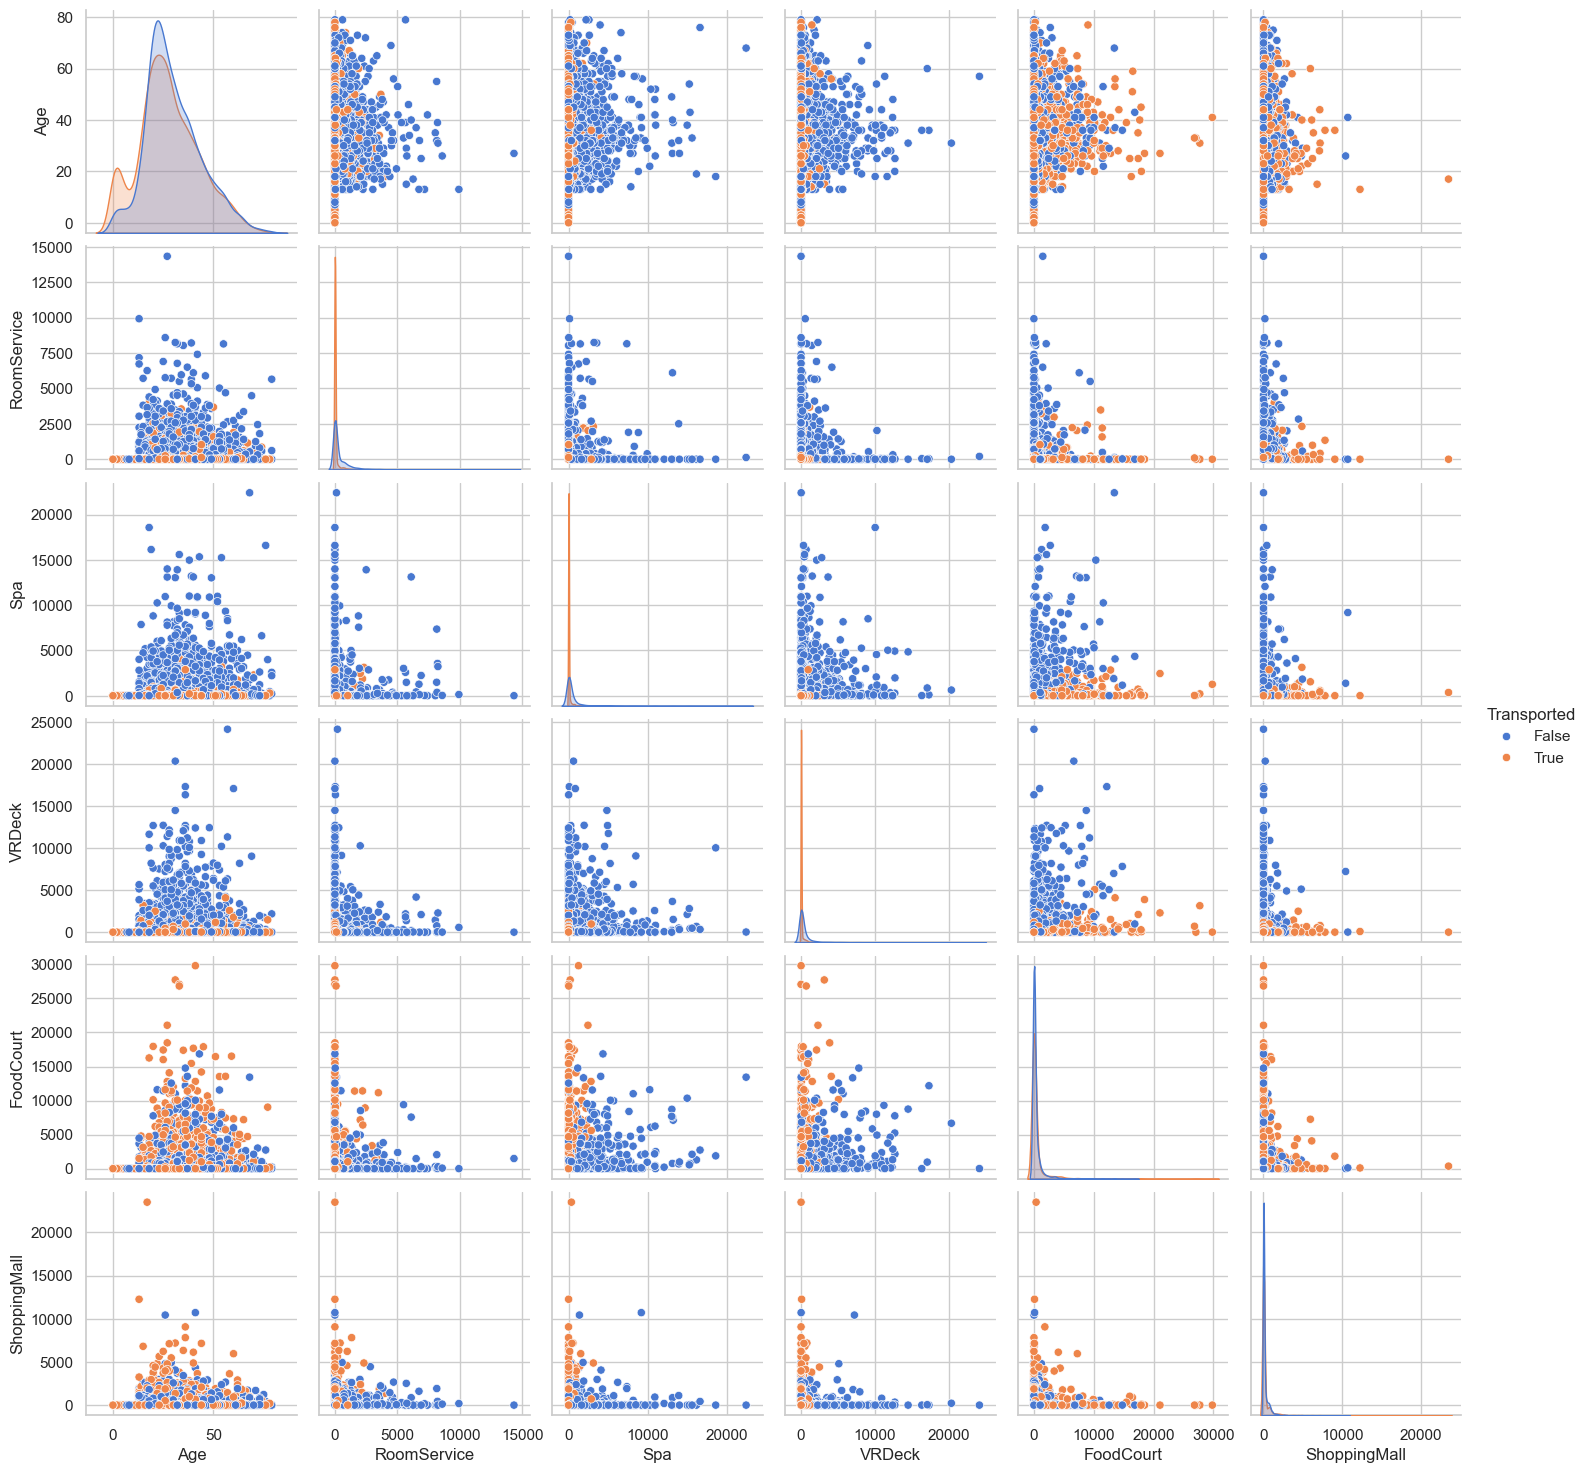

In [16]:
# Bivariate analysis through pairplots
sns.pairplot(train, vars=num_cols, hue='Transported', diag_kind="kde")
plt.show()

- The pair plots are consistent with the observations made above.

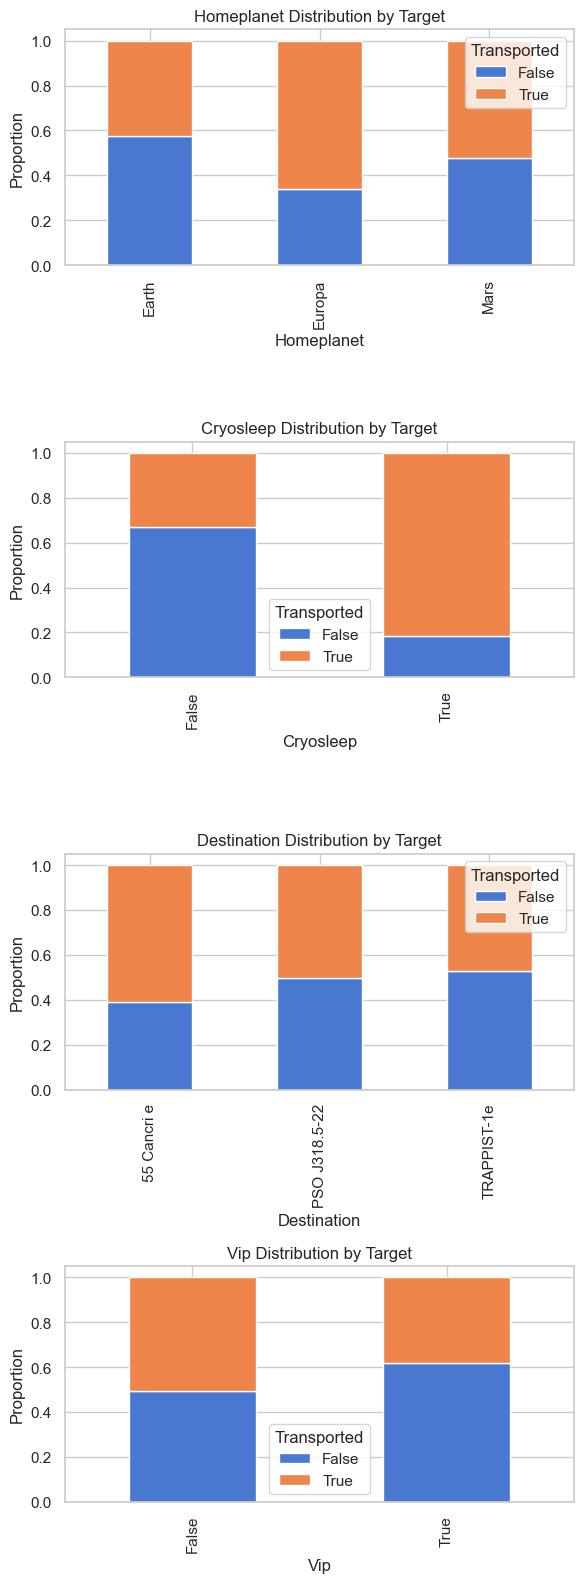

In [18]:
# Distrution of the categorical columns across different classes
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axs = plt.subplots(len(cat_cols), 1, figsize=(6, len(cat_cols) * 4))

for i, col in enumerate(cat_cols):
    contingency_table = pd.crosstab(train[col], train['Transported'], normalize='index')
    contingency_table.plot(kind='bar', stacked=True, ax=axs[i])
    axs[i].set_title(f"{col.title()} Distribution by Target")
    axs[i].set_xlabel(col.title())
    axs[i].set_ylabel("Proportion")
    
fig.tight_layout()
plt.show()

- A generous proportion of people from planet Europa were transported.
- The majority of people in Cryosleep state was transported, and a significant number of those who were not in Cryosleep remained safe.
- 55 Cancri e had the highest proportion of people transported.
- A little over of 60% of VIPs were transported.

In [20]:
# t-test
def perform_ttest(data, feature_list, target):    
    for feature in feature_list:
        sample_1 = data[data[target] == 0][feature]
        sample_2 = data[data[target] == 1][feature]
        
        t_stat, p_val = ttest_ind(sample_1, sample_2, nan_policy='omit')
        print(f'Feature: {feature} | t-value: {t_stat} | p-value: {p_val}')

perform_ttest(train, num_cols, 'Transported')

Feature: Age | t-value: 6.941461666045089 | p-value: 4.165050977554494e-12
Feature: RoomService | t-value: 23.27230572812196 | p-value: 3.400493892669515e-116
Feature: Spa | t-value: 20.914657362229097 | p-value: 9.275825095363414e-95
Feature: VRDeck | t-value: 19.517825470012635 | p-value: 4.9897017399892476e-83
Feature: FoodCourt | t-value: -4.299893771259008 | p-value: 1.727865340729664e-05
Feature: ShoppingMall | t-value: -0.934056481671101 | p-value: 0.3503013444989256


- Only ShoppingMall has a p-value greater than the significance level (0.05).
- This could indicate that this feature might add little value to the model; we'll see how it performs after transformations and preprocessing..

In [22]:
# Correlation between numeric columns
train[num_cols].corr()

,Age,RoomService,Spa,VRDeck,FoodCourt,ShoppingMall
Age,1.000000,0.068723,0.123970,0.101007,0.130421,0.033133
RoomService,0.068723,1.000000,0.010080,-0.019581,-0.015889,0.054480
Spa,0.123970,0.010080,1.000000,0.153821,0.221891,0.013879
VRDeck,0.101007,-0.019581,0.153821,1.000000,0.227995,-0.007322
FoodCourt,0.130421,-0.015889,0.221891,0.227995,1.000000,-0.014228
ShoppingMall,0.033133,0.054480,0.013879,-0.007322,-0.014228,1.000000


DATA CLEANING

In [24]:
# Splitting the Cabin variable into different columns.
train[['CabinDeck', 'CabinNumber', 'CabinSide']] = train['Cabin'].str.split('/', expand=True)
test[['CabinDeck', 'CabinNumber', 'CabinSide']] = test['Cabin'].str.split('/', expand=True)

In [25]:
# Converting booleans to int
# Test dataframe doesn't have a Transported attribute
def bool_to_int(data):
    if data==True:
        return 1
    elif data==False:
        return 0
    else:
        return np.nan

train['CryoSleep'] = train['CryoSleep'].apply(bool_to_int)
train['VIP'] = train['VIP'].apply(bool_to_int)
train['Transported'] = train['Transported'].apply(bool_to_int)

test['CryoSleep'] = test['CryoSleep'].apply(bool_to_int)
test['VIP'] = test['VIP'].apply(bool_to_int)

About the null values, I will handle some of them based on fundamental assumptions:
- Those in CryoSleep would neither be VIP nor have spent money on any facilities.
- I suspect there may be rare values in the categorical columns that are not represented in the dataset.

In [27]:
# Handling null values
def null_handling(data):
    exp_cols = ['RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Spa']

    # For each expense-related column, set the value to 0 for passengers in CryoSleep
    data['VIP'] = np.where(data['CryoSleep']==1, 0, data['VIP'])
    for col in exp_cols:
        data[col]=np.where(data["CryoSleep"]==1, 0, data[col])

    # Fill missing values with 'U' for CabinDeck and CabinSide
    # and 'Unknown' for HomePlanet and Destination
    # CryoSleep and VIP are filled with the most common value (0)
    data.fillna({'CabinDeck': 'U',
                 'CabinSide': 'U',
                 'HomePlanet': 'Unknown',
                 'Destination': 'Unknown',
                 'CryoSleep': 0,
                 'VIP': 0},
                inplace=True)

    # Drop columns that I don't believe are relevant to the prediction model
    data.drop(columns=['Cabin', 'Name', 'CabinNumber', 'PassengerId'], inplace=True)

null_handling(train)
null_handling(test)

In [28]:
# Applying log transformation (log(x + 1)) to spending variables and Age, so I could use KNNImputer afterwards.
num_cols = ['Age', 'RoomService', 'Spa', 'VRDeck', 'FoodCourt', 'ShoppingMall']

train[num_cols] = train[num_cols].apply(np.log1p)
test[num_cols] = test[num_cols].apply(np.log1p)

In [29]:
# Performing  KNN Imputation
knnimputer = KNNImputer(n_neighbors=5).fit(train[num_cols])

train[num_cols] = knnimputer.transform(train[num_cols])
test[num_cols] = knnimputer.transform(test[num_cols])

In [30]:
train.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
CabinDeck       0
CabinSide       0
dtype: int64

FEATURE ENGINEERING

In [32]:
# Defining spending variables
train['EntertainmentGoods'] = train['RoomService'] + train['Spa'] + train['VRDeck']
train['ConsumerGoods'] = train['ShoppingMall'] + train['FoodCourt']
train['Expenditure'] = train['EntertainmentGoods'] + train['ConsumerGoods']

test['EntertainmentGoods'] = test['RoomService'] + test['Spa'] + test['VRDeck']
test['ConsumerGoods'] = test['ShoppingMall'] + test['FoodCourt']
test['Expenditure'] = test['EntertainmentGoods'] + test['ConsumerGoods']

In [33]:
train.nunique()

HomePlanet               4
CryoSleep                2
Destination              4
Age                    171
VIP                      2
RoomService           1372
FoodCourt             1607
ShoppingMall          1215
Spa                   1437
VRDeck                1400
Transported              2
CabinDeck                9
CabinSide                3
EntertainmentGoods    4173
ConsumerGoods         2876
Expenditure           4960
dtype: int64

In [34]:
# Perfoming OneHot Encoding
onehot = OneHotEncoder(
    variables=['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide'],
    drop_last_binary=True
)

train = onehot.fit_transform(train)
test = onehot.fit_transform(test)

In [35]:
# Defining X and y
X = train.drop(columns=['Transported'])
y = train['Transported']

In [36]:
# Splitting the data between training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42)

In [37]:
# Baseline model
baseline_model = LogisticRegression(max_iter=1000,
                                    random_state=42)
baseline_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [38]:
# Baseline model predictions
baseline_predict = baseline_model.predict(X_valid)
baseline_acc_test = accuracy_score(y_valid, baseline_predict)
baseline_acc_test

0.7786083956296722

In [39]:
# Set up the RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Defining the hyperparameters to tune the model
params = {
    'n_estimators': [100, 250, 500, 1000],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize GridSearchCV
grid = GridSearchCV(model,
                    param_grid=params,
                    n_jobs=-1,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 5, 10],
                         'n_estimators': [100, 250, 500, 1000]},
             scoring='roc_auc')

In [40]:
# GridSearch best model predictions on validation set
y_valid_predict = grid.predict(X_valid)
acc_test = accuracy_score(y_valid, y_valid_predict)
acc_test

0.7958596894767107

In [41]:
# Calculate the difference in accuracy between the optimized model from GridSearchCV and the baseline model
acc_diff = (acc_test / baseline_acc_test) * 100
print(round(acc_diff - 100, 2), '%')

2.22 %


In [42]:
#Submission

# Ordering the test columns to fit the X_train columns
columns_order = X_train.columns
test = test[columns_order]

# Predict on the test set
test_predict = grid.predict(test)

submission_data = {
    'PassengerId': test_id,
    'Transported': test_predict
}

submission_df = pd.DataFrame(submission_data)
submission_df['Transported'] = submission_df['Transported'].astype(bool)

submission_df.to_csv('./data/submission.csv', sep=',', index=False)